# Problema 1: Comparación de métodos de clasificación

A partir del csv dado sobre artistas Billboard y algunas de sus características, debemos realizar un pequeño análisis exploratorio para conocer los datos, una vez hecho esto, deberemos utilizar un modelo de árbol de decisión y otros dos modelos más para que sean capaces de predecir (siempre y cuando existan correlaciones que lo permitan), a partir de características de una canción, si esta llegará a estar en el top o no. El objetivo final es comparar los tres modelos para a partir de su precisión saber cuál es más viable A PARTIR DEL ACCURACY.

## Pequeño análisis sobre el conjunto de datos

### Imports y creación del dataframe

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score          
%matplotlib inline     
sns.set(color_codes=True)

df = pd.read_csv('artists_billboard.csv')

### Exploración inicial de los datos

In [2]:
## Una vista a la estructura general del dataframe
print(df.head())

   id                 title  \
0   0  Small Town Throwdown   
1   1             Bang Bang   
2   2                Timber   
3   3       Sweater Weather   
4   4             Automatic   

                                              artist        mood  \
0  BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...    Brooding   
1              JESSIE J, ARIANA GRANDE & NICKI MINAJ  Energizing   
2                            PITBULL featuring KE$HA     Excited   
3                                  THE NEIGHBOURHOOD    Brooding   
4                                    MIRANDA LAMBERT    Yearning   

          tempo               genre artist_type  chart_date  durationSeg  top  \
0  Medium Tempo         Traditional        Male    20140628        191.0    0   
1  Medium Tempo                 Pop      Female    20140816        368.0    0   
2  Medium Tempo               Urban       Mixed    20140118        223.0    1   
3  Medium Tempo  Alternative & Punk        Male    20140104        206.0    0   

In [3]:
## Saber el número total de filas y columnas
num_filas, num_columnas = df.shape
print("Número total de filas:", num_filas)
print("Número total de columnas:", num_columnas)

Número total de filas: 635
Número total de columnas: 11


In [4]:
## Saber el tipo de datos de cada columna
tipos_de_datos = df.dtypes
print(tipos_de_datos)

id                  int64
title              object
artist             object
mood               object
tempo              object
genre              object
artist_type        object
chart_date          int64
durationSeg       float64
top                 int64
anioNacimiento    float64
dtype: object


In [5]:
## Saber si contamos con valores nulos en las columnas
valores_nulos = df.isnull().sum()
print(valores_nulos)

id                0
title             0
artist            0
mood              0
tempo             0
genre             0
artist_type       0
chart_date        0
durationSeg       0
top               0
anioNacimiento    0
dtype: int64


In [6]:
## Ver si en las columnas numéricas hay ceros
columnas_numericas = df.select_dtypes(include=['int', 'float'])
registros_con_0 = (columnas_numericas == 0).sum()
print(registros_con_0)

id                  1
chart_date          0
durationSeg        31
top               494
anioNacimiento    139
dtype: int64


In [7]:
## Ver los valores únicos en las columnas categóricas
columnas_caracteres = df.select_dtypes(include=['object'])
valores_unicos_caracteres = columnas_caracteres.nunique()
print(valores_unicos_caracteres)

title          626
artist         423
mood            23
tempo            3
genre            9
artist_type      3
dtype: int64


Con esta exploración inicial puedo sacar algunas conclusiones sobre el conjunto de datos:
- La completitud es muy buena, no hay registros con columnas vacías.
- La cantidad de registros (635) es viable para entrenar al modelo.
- Hay variables con las que se debe realizar one-hot-encoding: mood, tempo, genre y artist_type.
- Los ceros en el campo "anioNacimiento" son preocupantes, puesto que es un dato difícil de imputar.
- Los valores "cero" en el campo "durationSeg" son algo a tener en cuenta, aunque haya solamente 31.

### Eliminación de columnas y renombres

In [8]:
correlacion = df['anioNacimiento'].corr(df['top'])
print("Correlación entre año de nacimiento del artista y top:", correlacion)

df = df.drop(['id','artist','chart_date','anioNacimiento','title'], axis = 1)
df = df.rename(columns={"mood": "Vibra","tempo": "Tempo","genre": "Genero","artist_type": "Sexo","durationSeg": "Duracion_seg","top": "Top"})

df.head(1)

Correlación entre año de nacimiento del artista y top: 0.2728852482637659


,Vibra,Tempo,Genero,Sexo,Duracion_seg,Top
0,Brooding,Medium Tempo,Traditional,Male,191.0,0


He decidido eliminar estas columnas puesto que de primeras no son muy útiles para predecir si una canción estará en el top por sus características. El año de nacimiento tiene una muy pequeña correlación de 0.2, pero al tener tantos valores en cero no es fiable, borrar tantos registros no es una opción viable e imputarlos tampoco, ya que si se hiciese con media o mediana alteraría mucho la distribución de edades y los datos dejarían de ser creíbles.  
He puesto el nombre de las columnas en español para que me sea más sencillo trabajar con ellas.

### Conversión e imputación de datos

In [9]:
df_encoded = pd.get_dummies(df, columns=['Sexo', 'Tempo', 'Genero','Vibra'], dtype=int)
df_encoded.head(1)

,Duracion_seg,Top,Sexo_Female,Sexo_Male,Sexo_Mixed,Tempo_Fast Tempo,Tempo_Medium Tempo,Tempo_Slow Tempo,Genero_Alternative & Punk,Genero_Electronica,...,Vibra_Peaceful,Vibra_Romantic,Vibra_Rowdy,Vibra_Sensual,Vibra_Sentimental,Vibra_Sophisticated,Vibra_Stirring,Vibra_Upbeat,Vibra_Urgent,Vibra_Yearning
0,191.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con tal de hacer más sencillo para el modelo tratar con los datos, he hecho "one-hot-encoding" en todas las variables categóricas, para convertirlas en numéricas.  
En algunos campos, como "Sexo", donde las opciones son pocas, podría haber convertido simplemente los valores a números, en este caso, por ejemplo, 0,1 y 2. He preferido hacer one-hot-encoding ya que investigando he descubierto que hacerlo convirtiendo datos directamente en vez de creando nuevas columnas con el one-hot, puede hacer que el modelo tome un orden implícito de los datos aunque no exista.


Valores con 0 en duración: 31/635
Correlación entre la duración de la canción y el top: -0.04906609595764927
Número de registros donde Duracion_seg supera los 300 (5 minutos): 91
Número de registros donde Duracion_seg es menor que 60 (1 min) (excluyendo 0): 10


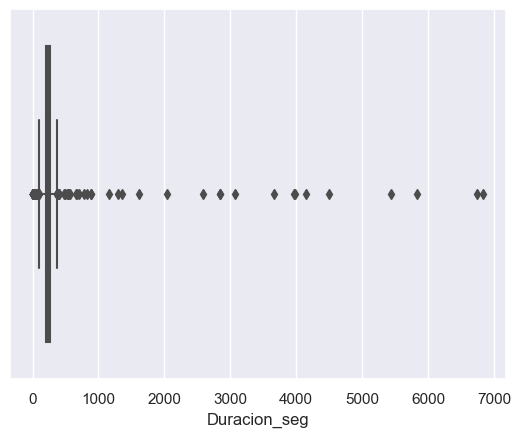

In [10]:
registros_con_0 = (df_encoded['Duracion_seg'] == 0).sum()
print("Valores con 0 en duración: " + str(registros_con_0) + "/635")

sns.boxplot(x=df['Duracion_seg'])

correlacion = df['Duracion_seg'].corr(df['Top'])
print("Correlación entre la duración de la canción y el top:", correlacion)

registros_mayores_a_300 = (df_encoded['Duracion_seg'] > 300).sum()
print("Número de registros donde Duracion_seg supera los 300 (5 minutos):", registros_mayores_a_300)

registros_menores_a_60_excluyendo_0 = ((df_encoded['Duracion_seg'] < 60) & (df_encoded['Duracion_seg'] != 0)).sum()
print("Número de registros donde Duracion_seg es menor que 60 (1 min) (excluyendo 0):", registros_menores_a_60_excluyendo_0)

Con estas líneas de código consigo información sobre el campo "Duracion_seg":
- Hay 31 registros sin la duración especificada.
- No existe correlación entre la duración de las canciones y su puesto en el top.
- Hay outliers muy marcados con números ilógicos.
- Hay 91 registros por encima de los 5 minutos y 10 por debajo del minuto.  
  
Haciendo una búsqueda un poco más específica de información, he mirado manualmente algunas filas del dataset y he encontrado que muchos datos de la columna están mal puestos, cosa que ya se dejaba ver por el boxplot, puesto que canciones de más de 500 segundos, por ejemplo, son raras de ver, pero con 6000-7000 es imposible. Inspeccionando un poco los primeros registros he visto que por ejemplo, la canción Grenade de Bruno Mars, dura 700 segundos (realmente dura 3 minutos), Odio, de Romeo Santos dura 7000 segundos (realmente dura 3 minutos 45 segundos)...  
  
Con esta información llego a la conclusión de que por su poca correlación es una columna poco importante y que tiene demasiados datos mal, tanto vacíos como outliers, por lo que lo más lógico es eliminarla, puesto que eliminando outliers y valores vacíos se perderían demasiados registros e imputando con media o mediana, por ejemplo, la distribución de los datos no sería realista.

In [11]:
df_encoded = df_encoded.drop(['Duracion_seg'], axis = 1)
df_encoded.head(1)

,Top,Sexo_Female,Sexo_Male,Sexo_Mixed,Tempo_Fast Tempo,Tempo_Medium Tempo,Tempo_Slow Tempo,Genero_Alternative & Punk,Genero_Electronica,Genero_Jazz,...,Vibra_Peaceful,Vibra_Romantic,Vibra_Rowdy,Vibra_Sensual,Vibra_Sentimental,Vibra_Sophisticated,Vibra_Stirring,Vibra_Upbeat,Vibra_Urgent,Vibra_Yearning
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Correlaciones

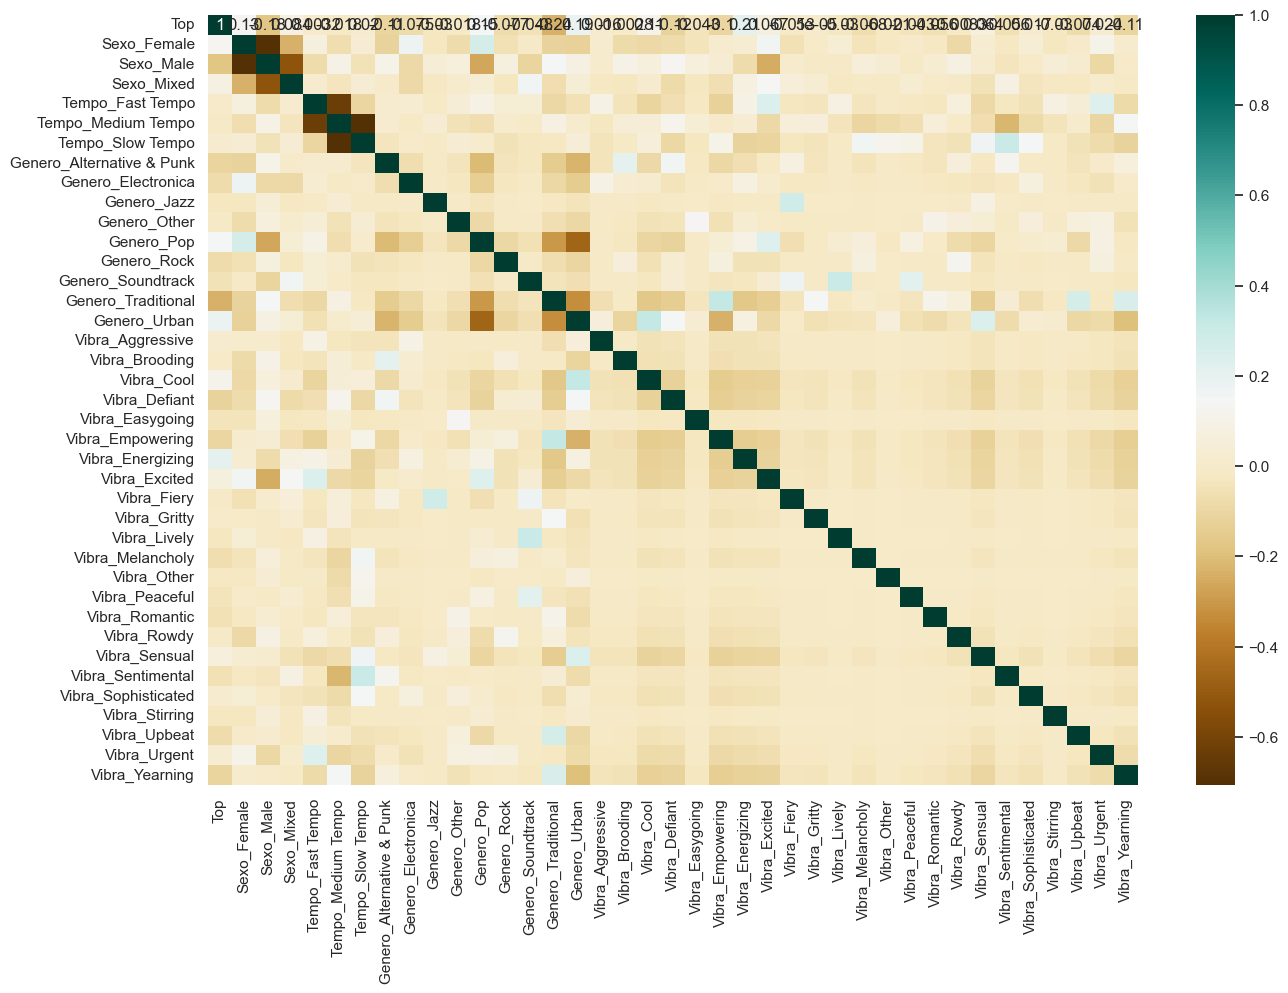

In [12]:
df_numeric = df_encoded.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(15, 10))
corr = df_numeric.corr()
sns.heatmap(corr, cmap="BrBG", annot=True)
plt.show()

Como es observable, mediante el mapa de calor es difícil distinguir la correlación entre variables, aunque ya se detecta que hay poca. Para verlo mejor he hecho un gráfico con puntos para cada grupo:

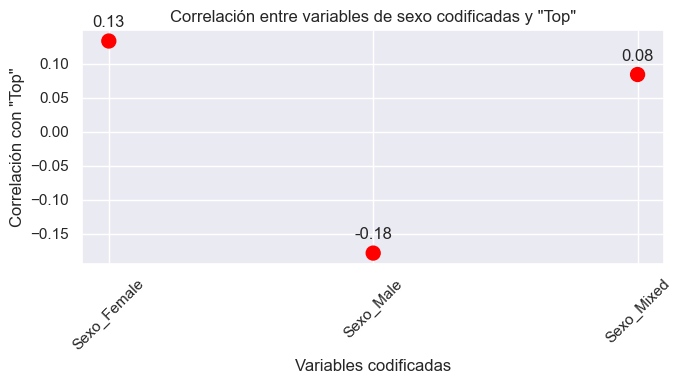

In [13]:
# Seleccionar solo las variables codificadas en one-hot encoding relacionadas con el sexo
variables_codificadas = df_encoded.filter(regex='^Sexo_')

# Calcular la matriz de correlación con "Top"
correlation_matrix = variables_codificadas.corrwith(df_encoded['Top'])

# Obtener nombres de variables codificadas
variable_names = correlation_matrix.index

# Colores basados en la correlación
colors = np.where(correlation_matrix > 0.15, 'green', 'red')

# Crear gráfico de dispersión
plt.figure(figsize=(7, 4))
plt.scatter(range(len(correlation_matrix)), correlation_matrix.values, s=100, c=colors)
plt.xticks(range(len(correlation_matrix)), variable_names, rotation=45)
plt.xlabel('Variables codificadas')
plt.ylabel('Correlación con "Top"')
plt.title('Correlación entre variables de sexo codificadas y "Top"')

# Agregar etiquetas a los puntos
for i, txt in enumerate(correlation_matrix.values):
    plt.annotate("{:.2f}".format(txt), (i, correlation_matrix.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

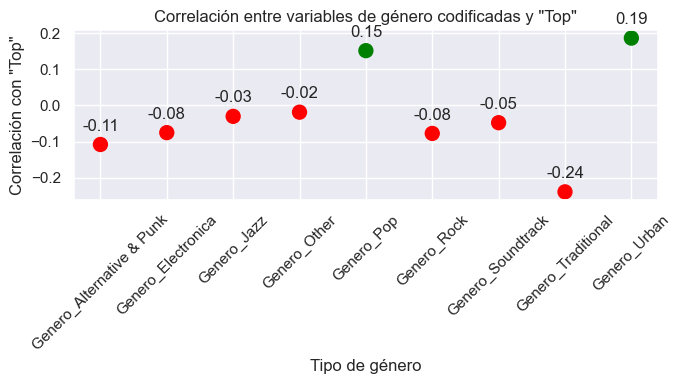

In [14]:
# Seleccionar solo las variables codificadas en one-hot encoding relacionadas con el género
variables_codificadas = df_encoded.filter(regex='^Genero')

# Calcular la matriz de correlación con "Top"
correlation_matrix = variables_codificadas.corrwith(df_encoded['Top'])

# Obtener nombres de variables codificadas
variable_names = correlation_matrix.index

# Colores basados en la correlación
colors = np.where(correlation_matrix > 0.15, 'green', 'red')

# Crear gráfico de dispersión
plt.figure(figsize=(7, 4))
plt.scatter(range(len(correlation_matrix)), correlation_matrix.values, s=100, c=colors)
plt.xticks(range(len(correlation_matrix)), variable_names, rotation=45)
plt.xlabel('Tipo de género')
plt.ylabel('Correlación con "Top"')
plt.title('Correlación entre variables de género codificadas y "Top"')

# Agregar etiquetas a los puntos
for i, txt in enumerate(correlation_matrix.values):
    plt.annotate("{:.2f}".format(txt), (i, correlation_matrix.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

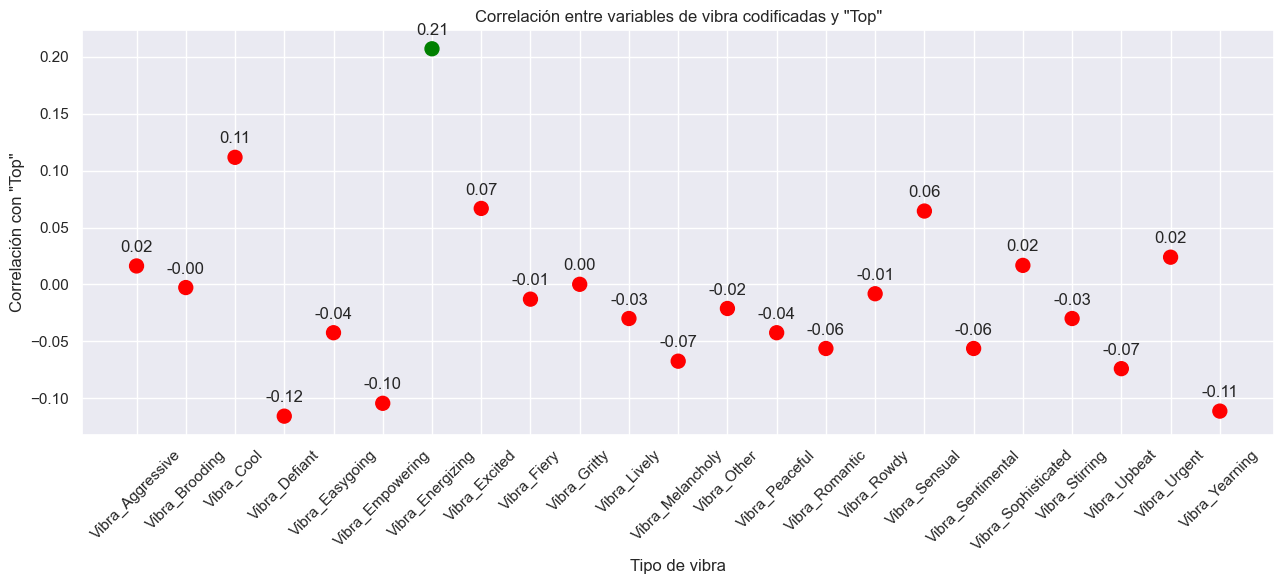

In [15]:
# Seleccionar solo las variables codificadas en one-hot encoding relacionadas con la vibra
variables_codificadas = df_encoded.filter(regex='^Vibra')

# Calcular la matriz de correlación con "Top"
correlation_matrix = variables_codificadas.corrwith(df_encoded['Top'])

# Obtener nombres de variables codificadas
variable_names = correlation_matrix.index

# Colores basados en la correlación
colors = np.where(correlation_matrix > 0.15, 'green', 'red')

# Crear gráfico de dispersión
plt.figure(figsize=(13, 6))
plt.scatter(range(len(correlation_matrix)), correlation_matrix.values, s=100, c=colors)
plt.xticks(range(len(correlation_matrix)), variable_names, rotation=45)
plt.xlabel('Tipo de vibra')
plt.ylabel('Correlación con "Top"')
plt.title('Correlación entre variables de vibra codificadas y "Top"')

# Agregar etiquetas a los puntos
for i, txt in enumerate(correlation_matrix.values):
    plt.annotate("{:.2f}".format(txt), (i, correlation_matrix.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

En estos gráficos se pueden ver las correlaciones para los distintos sexos, géneros y vibras. Los puntos solo aparecen en verde cuando su correlación es igual o superior a 0.15. En este caso, los únicos puntos que cumplen con este valor en correlación con el puesto en top es la vibra energizante y el género pop y urbano. En cuanto a sexos, el más relacionado con el top es el femenino. Hay muchas correlaciones negativas pero no llegan a ser tan altas como para poder decir que tenemos una correlación inversa a tener en cuenta en muchas variables, las que más destacan son el sexo masculino y el género tradicional.  
Con esto podríamos decir que la canción ideal para el top sería cantada por una mujer, con vibra energizante y de género urbano (en reglas generales).

## Modelos

Una vez tenemos información, aunque sea básica, sobre el conjunto de datos a tratar y el dataframe está limpio y preparado para el modelo, es hora de crearlo.

### Árbol de decisión

In [24]:
# Separar las características (variables independientes) y la variable objetivo
X = df_encoded.drop('Top', axis=1)
y = df_encoded['Top']

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de árbol de decisión:", accuracy)


Precisión del modelo de árbol de decisión: 0.7905759162303665


### KNN

In [23]:
# Separar las características (variables independientes) y la variable objetivo
X = df_encoded.drop('Top', axis=1)
y = df_encoded['Top']

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Especifica el número de vecinos

# Entrenar el modelo
knn.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = knn.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo KNN:", accuracy)

Precisión del modelo KNN: 0.7958115183246073


### Regresión logística

In [22]:
# Separar las características (variables independientes) y la variable objetivo
X = df_encoded.drop('Top', axis=1)
y = df_encoded['Top']

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de regresión logística
logistic_regression = LogisticRegression()

# Entrenar el modelo
logistic_regression.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = logistic_regression.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de regresión logística:", accuracy)

Precisión del modelo de regresión logística: 0.8115183246073299


### Random Forest

In [21]:
# Separar las características (variables independientes) y la variable objetivo
X = df_encoded.drop('Top', axis=1)
y = df_encoded['Top']

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Entrenar el modelo
random_forest.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = random_forest.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de Random Forest:", accuracy)

Precisión del modelo de Random Forest: 0.7958115183246073


### Conclusiones

Después de realizar experimentos utilizando diferentes modelos de aprendizaje automático para predecir si una canción llegará al top o no, hemos obtenido los siguientes resultados de precisión:

- Precisión del modelo de regresión logística: 0.8115
- Precisión del modelo de Random Forest: 0.7958
- Precisión del modelo KNN: 0.7958
- Precisión del modelo de árbol de decisión: 0.7906

Estos resultados nos ofrecen una visión valiosa sobre el rendimiento de cada modelo en nuestro conjunto de datos de canciones. La regresión logística ha mostrado la precisión más alta entre los modelos evaluados, con un valor de aproximadamente 0.8115. Esto sugiere que la regresión logística es capaz de generalizar mejor para predecir si una canción llegará al top o no en comparación con los otros modelos.

La regresión logística, al ser un modelo más simple y menos propenso al sobreajuste, puede generalizar mejor los patrones en el conjunto de datos más pequeño y proporcionar resultados más estables y confiables. Por otro lado, modelos más complejos como Random Forest, KNN y árbol de decisión pueden ser más susceptibles al sobreajuste, especialmente en conjuntos de datos pequeños como el que tenemos con solo 635 registros.

Por lo tanto, el tamaño del conjunto de datos también podría ser un factor importante que contribuye a la superioridad de la regresión logística en este caso. En general, es recomendable probar varios modelos y evaluar su rendimiento en diferentes tamaños de conjunto de datos para determinar cuál es el más adecuado para el problema específico que estamos abordando.

En resumen, la elección del modelo más adecuado depende de varios factores, como la complejidad del problema, la disponibilidad de datos y la interpretabilidad del modelo. En este caso, la regresión logística ha demostrado ser una opción sólida debido a su simplicidad, capacidad de generalización y fácil interpretación.
